In [3]:
import pandas as pd

In [4]:
df = pd.read_excel("./WindPowerForecastingData.xlsx")

print(df.head())


       TIMESTAMP  TARGETVAR       U10       V10      U100      V100
0  20120101 1:00   0.000000  2.124600 -2.681966  2.864280 -3.666076
1  20120101 2:00   0.054879  2.521695 -1.796960  3.344859 -2.464761
2  20120101 3:00   0.110234  2.672210 -0.822516  3.508448 -1.214093
3  20120101 4:00   0.165116  2.457504 -0.143642  3.215233 -0.355546
4  20120101 5:00   0.156940  2.245898  0.389576  2.957678  0.332701


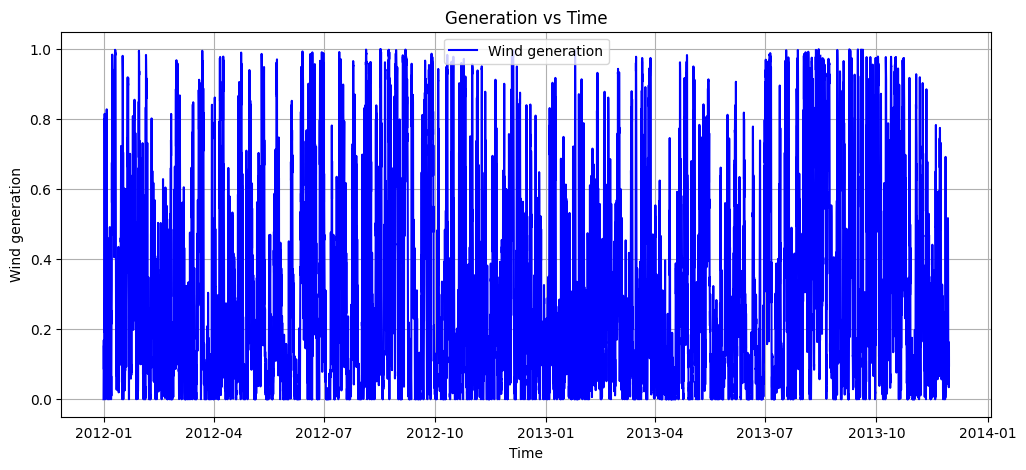

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already loaded
# Parse TIMESTAMP correctly
df["DATETIME"] = pd.to_datetime(df["TIMESTAMP"], format="%Y%m%d %H:%M")

# Plot TARGETVAR vs time
plt.figure(figsize=(12,5))
plt.plot(df["DATETIME"], df["TARGETVAR"], label="Wind generation", color="blue")

plt.xlabel("Time")
plt.ylabel("Wind generation")
plt.title("Generation vs Time")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pandas as pd

# Assuming df is your DataFrame
print(df.isnull().values.any())
print(df.isnull().sum())


True
TIMESTAMP     0
TARGETVAR    35
U10           0
V10           0
U100          0
V100          0
DATETIME      0
dtype: int64


In [7]:
# Assuming df is your DataFrame
print(df.shape)


(16800, 7)


In [8]:
df_clean = df.dropna()
print(df_clean.isnull().values.any())

False


In [9]:
# Assuming df is your original DataFrame
df_new1 = df_clean.drop(columns=["TIMESTAMP"])

# Check the new DataFrame
print(df_new1.head())


   TARGETVAR       U10       V10      U100      V100            DATETIME
0   0.000000  2.124600 -2.681966  2.864280 -3.666076 2012-01-01 01:00:00
1   0.054879  2.521695 -1.796960  3.344859 -2.464761 2012-01-01 02:00:00
2   0.110234  2.672210 -0.822516  3.508448 -1.214093 2012-01-01 03:00:00
3   0.165116  2.457504 -0.143642  3.215233 -0.355546 2012-01-01 04:00:00
4   0.156940  2.245898  0.389576  2.957678  0.332701 2012-01-01 05:00:00


In [10]:
import pandas as pd

# Assuming df is your cleaned DataFrame (no nulls)
corr_matrix = df_new1.corr()
print(corr_matrix)


           TARGETVAR       U10       V10      U100      V100  DATETIME
TARGETVAR   1.000000  0.380003 -0.192178  0.367991 -0.201522  0.057833
U10         0.380003  1.000000 -0.087434  0.979927 -0.047560  0.089689
V10        -0.192178 -0.087434  1.000000 -0.127588  0.979846 -0.101615
U100        0.367991  0.979927 -0.127588  1.000000 -0.090110  0.096062
V100       -0.201522 -0.047560  0.979846 -0.090110  1.000000 -0.105132
DATETIME    0.057833  0.089689 -0.101615  0.096062 -0.105132  1.000000


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [12]:

# =========================
# 1. Load & preprocess data
# =========================
# Assume df is your dataframe with TARGETVAR + features
df_new = df_clean.drop(columns=["TIMESTAMP","DATETIME"])  # drop timestamp

data = df_new.values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [13]:
# =========================
# 2. Create sequences
# =========================
n_steps = 3  # lookback steps
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i, 1:])  # features
    y.append(scaled_data[i, 0])             # target

X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

dataset = TensorDataset(X_tensor, y_tensor)

# Train-test split
train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [14]:
# =========================
# 3. Define LSTM (NO class)
# =========================
input_size = X_tensor.shape[2]
hidden_size = 50
num_layers = 1

lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
fc = nn.Linear(hidden_size, 1)



In [15]:
# =========================
# 4. Train loop
# =========================
criterion = nn.MSELoss()
params = list(lstm.parameters()) + list(fc.parameters())
optimizer = optim.Adam(params, lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        out, _ = lstm(X_batch)
        out = out[:, -1, :]     # last step
        y_pred = fc(out)

        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

# =========================
# 5. Prediction
# =========================
lstm.eval()
fc.eval()
y_test_pred = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        out, _ = lstm(X_batch)
        out = out[:, -1, :]
        y_pred = fc(out)
        y_test_pred.append(y_pred)

y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

# Inverse scaling
y_test_original = scaler.inverse_transform(
    np.hstack([y_tensor[train_size:].numpy(), np.zeros((len(y_tensor)-train_size, scaled_data.shape[1]-1))])
)[:,0]

y_pred_original = scaler.inverse_transform(
    np.hstack([y_test_pred, np.zeros((y_test_pred.shape[0], scaled_data.shape[1]-1))])
)[:,0]



Epoch 10/50, Loss: 0.053260
Epoch 20/50, Loss: 0.050657
Epoch 30/50, Loss: 0.045503
Epoch 40/50, Loss: 0.038496
Epoch 50/50, Loss: 0.032925


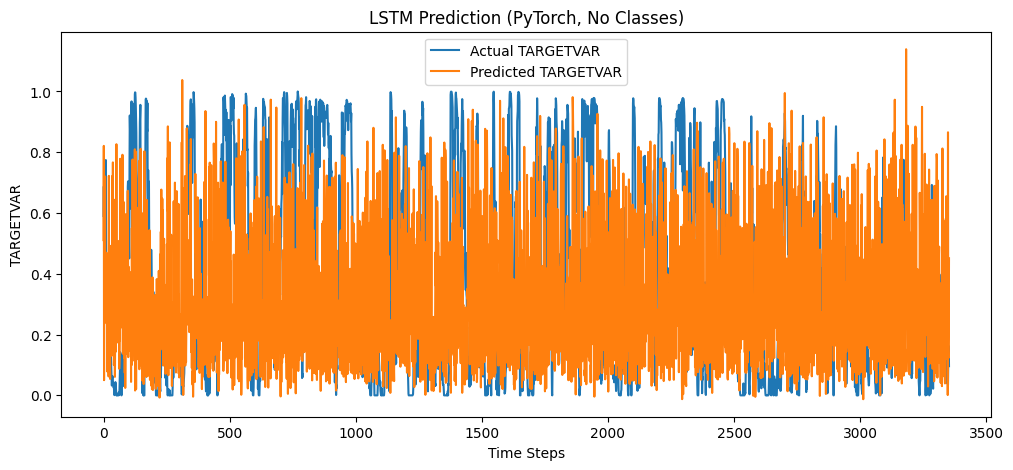

In [16]:
# =========================
# 6. Plot results
# =========================
plt.figure(figsize=(12,5))
plt.plot(y_test_original, label="Actual TARGETVAR")
plt.plot(y_pred_original, label="Predicted TARGETVAR")
plt.xlabel("Time Steps")
plt.ylabel("TARGETVAR")
plt.title("LSTM Prediction (PyTorch, No Classes)")
plt.legend()
plt.show()


In [17]:
torch.save({
    "lstm_state_dict": lstm.state_dict(),
    "fc_state_dict": fc.state_dict(),
    "scaler": scaler  # saves your MinMaxScaler too
}, "lstm_model.pth")
